In [0]:
import json
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
host="https://7771acde721f4a6bafa7cc6819bf7a45.us-east-1.aws.found.io:9243"
username = "onur"
pw = ""
es = Elasticsearch([host], http_auth=(username,pw))


In [0]:
res = es.search(
    index="tracking_events_prod",
    body={
        "query": 
        {
            "match": {
                "entity.keyword": "Donald Trump"
            }
        }
    },
    size=1000,
    request_timeout=50
)




{
 "took": 12146,
 "timed_out": false,
 "_shards": {
  "total": 1,
  "successful": 1,
  "skipped": 0,
  "failed": 0
 },
 "hits": {
  "total": {
   "value": 9190,
   "relation": "eq"
  },
  "max_score": 5.85115,
  "hits": [
   {
    "_index": "tracking_events_prod",
    "_type": "tracking_event",
    "_id": "g8Brjm4BXLoIPyi2vZpR",
    "_score": 5.85115,
    "_source": {
     "publisher_id": "5d9664316afc51796de5ecb4",
     "article_id": "5681116",
     "entity": "Donald Trump",
     "source": "DESKTOP",
     "ip_addr": "217.227.236.139",
     "user_agent_platform": "windows",
     "user_agent_browser": "chrome",
     "user_agent_version": "78.0.3904.108",
     "user_agent_string": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36",
     "http_origin": "https://www.inquisitr.com",
     "event_name": "entity_hover_event",
     "event_datetime": "2019-11-21T14:44:15.822788",
     "environment": "production",
     "geo_countr

In [0]:
elastic_docs = res["hits"]["hits"]
print ("documents returned:", len(elastic_docs))

documents returned: 1000


In [0]:
source_data = []
for num, doc in enumerate(elastic_docs):
    source_data.append(doc["_source"])


In [0]:
fields = {}
for i in range(len(source_data)):
    for key, val in source_data[i].items():
        try:
            fields[key] = np.append(fields[key], val)
        except KeyError:
            fields[key] = np.array([val])
fields.pop('related_article_id')

In [0]:
elastic_df = pd.DataFrame(fields)
elastic_df.head(1)

,publisher_id,article_id,entity,source,ip_addr,user_agent_platform,user_agent_browser,user_agent_version,user_agent_string,http_origin,event_name,event_datetime,environment,geo_country,geo_city
0,5d9664316afc51796de5ecb4,5681116,Donald Trump,DESKTOP,217.227.236.139,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,https://www.inquisitr.com,entity_hover_event,2019-11-21T14:44:15.822788,production,DE,Wietze


In [0]:
elastic_df = elastic_df.drop(['environment'], axis=1) # useless infrom
elastic_df.describe()

,publisher_id,article_id,entity,source,ip_addr,user_agent_platform,user_agent_browser,user_agent_version,user_agent_string,http_origin,event_name,event_datetime,geo_country,geo_city
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,998,1000,1000,997,928
unique,5,226,1,2,812,7,8,81,375,7,2,1000,48,502
top,5d9664316afc51796de5ecb4,5771122,Donald Trump,DESKTOP,96.242.116.28,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-25T19:34:17.239717,US,Caldwell
freq,751,151,1000,739,29,485,657,230,84,751,942,1,833,30


In [0]:
def cutSeconds(Time):
    temp = ""
    for i in range(len(Time)):
        if Time[i] == ".":
            return temp
        temp += Time[i]
    return Time

elastic_df['event_datetime'] = elastic_df["event_datetime"].apply(cutSeconds)

In [0]:
elastic_df["event_datetime"] = pd.to_datetime( elastic_df["event_datetime"])
elastic_df["time"] = elastic_df["event_datetime"].dt.time
elastic_df["day"] = elastic_df["event_datetime"].dt.date

In [0]:
elastic_df.head(2)

,publisher_id,article_id,entity,source,ip_addr,user_agent_platform,user_agent_browser,user_agent_version,user_agent_string,http_origin,event_name,event_datetime,geo_country,geo_city,24hour_bucket,Date,time,day
0,5d9664316afc51796de5ecb4,5681116,Donald Trump,DESKTOP,217.227.236.139,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,https://www.inquisitr.com,entity_hover_event,2019-11-21 14:44:15,DE,Wietze,NaT,2019-11-21,14:44:15,2019-11-21
1,5d9664316afc51796de5ecb4,5750395,Donald Trump,DESKTOP,66.98.98.135,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-21 14:38:33,US,None,NaT,2019-11-21,14:38:33,2019-11-21


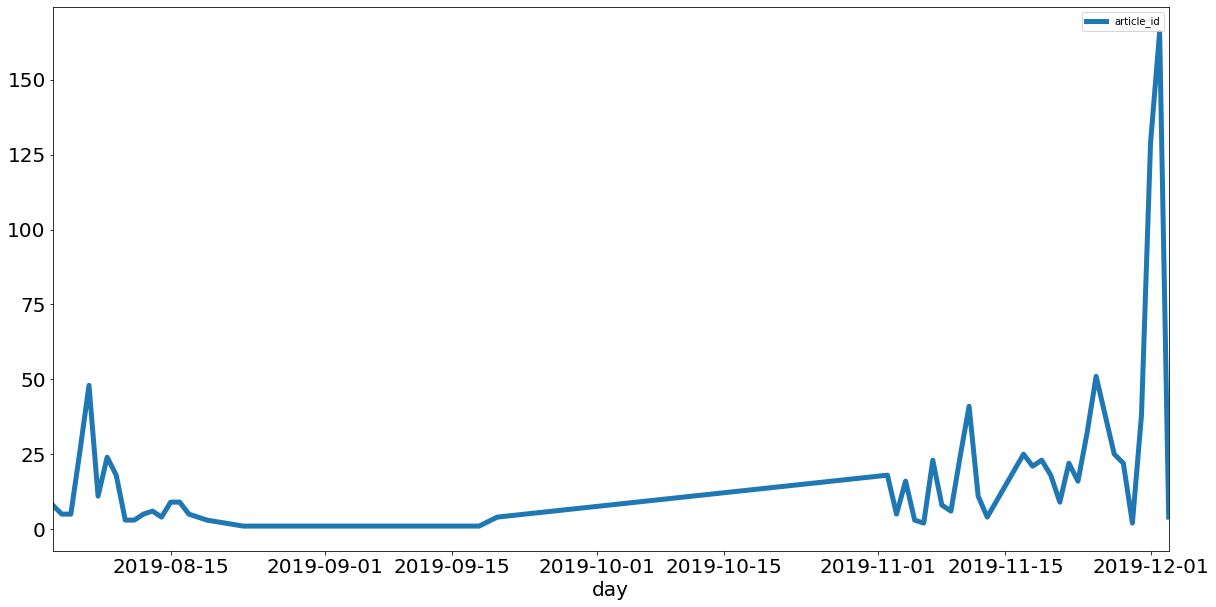

In [0]:
daily_freq = pd.DataFrame(columns = ["article_id", "day"])
daily_freq[["article_id", "day"]] = elastic_df[["article_id", "day"]]
daily_freq = daily_freq.groupby("day").count()
daily_freq.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('day', fontsize=20);

In [0]:
time_freq = pd.DataFrame(columns = ["article_id", "time"])
time_freq["time"] = elastic_df["time"]
time_freq["article_id"] = elastic_df["article_id"]
time_freq['time'] = pd.to_datetime(time_freq['time'], format= "%H:%M:%S").dt.hour

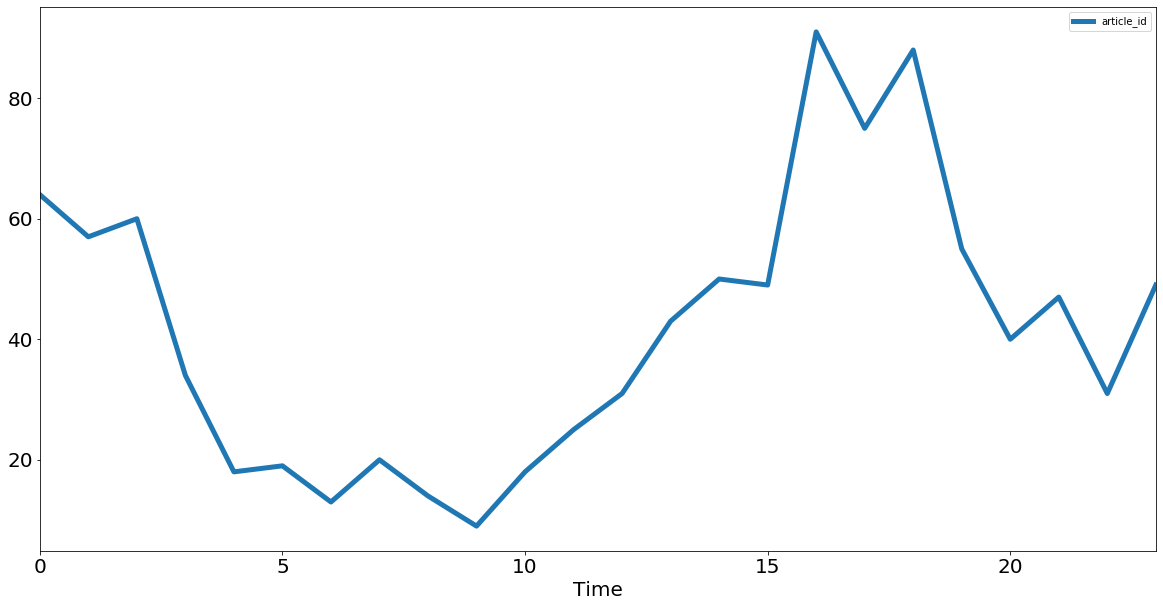

In [0]:
time_freq = time_freq.groupby("time").count()
time_freq.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Time', fontsize=20);
